<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=2
# MODEL_USED="facebook/nllb-200-distilled-600M"
MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_wayuu_esp_sin_dict_1_3B-V2"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="way_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/wayuu_completo_sin_dic_v2.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="way"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(7635, 2)
Index(['way', 'esp'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6108 entries, 216 to 7270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   way     6108 non-null   object
 1   esp     6108 non-null   object
dtypes: object(2)
memory usage: 143.2+ KB


In [9]:
df_train.head()

,way,esp
216,"Antüsü wanee palajana, antüsü wanee mapan.","Llegó primero una, llegó otra después."
4383,Nüsouktakalaka Jesús nümüin:—Tamüsü paala pümü...,Jesús le contestó:—El que me ama de verdad se ...
5163,Anainja tojuittüle yaajee tale'ejaiwa nünainmü...,"Volveré a mi padre y le diré: Padre, he pecado..."
421,¿Eesü asalaa cha ꞌaya suluꞌu aikaaleekalü?,¿Hay carne allá en la tienda?
505,"Aa, antajachi taya si'iralüin müshia ekirajaai...","Si, el profesor me dijo que viniera en guayuco..."


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763 entries, 5981 to 5799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   way     763 non-null    object
 1   esp     763 non-null    object
dtypes: object(2)
memory usage: 17.9+ KB


In [11]:
df_dev.head()

,way,esp
5981,"Sükajee tüü, shii'iyatüin tamüin tojut süpülap...",Ha hecho lo que estaba en su mano preparando p...
3491,Nükumajüin shia Maleiwakai süpüla süchajaainja...,"Y esto para ver si, aunque fuese a tientas, pu..."
6276,Ni'rapa Jesús tü wayuu wattakat saalin nü'ütpa...,"Viendo Jesús que lo rodeaba una gran multitud,..."
265,¿Kasa paa Ꞌinraka?,¿Qué haces?
3210,Je ni'rataalain naa'in wane wayuu kanüliashi A...,y acaba de tener una visión en la que un hombr...


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 764 entries, 4233 to 682
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   way     764 non-null    object
 1   esp     764 non-null    object
dtypes: object(2)
memory usage: 17.9+ KB


In [13]:
df_test.head()

,way,esp
4233,Wanaa sümaa naapinnüin nüchiki Lázaro sünain a...,"Jesús tenía una gran amistad con Marta, con su..."
5827,“Je jalia pia suulia kaainjalaa sükajee tü kas...,Y si tu pie va a ser causa de que caigas en pe...
6131,eeinjanale kepiain naya wane'ere'eya ouktapa H...,donde permaneció hasta la muerte de Herodes. A...
7628,Joutaa mama anterru joluu,Y también viene tu mamá
4325,"Süka jamüin, tü taküjakat, nnojotsü tale'eru'u...","Porque yo no hablo por mi cuenta; el Padre, qu..."


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,way,way_words,way_toks
3147,dijeron Aarón: Haznos dioses que nos guíen en ...,"[dijeron, Aarón, :, Haznos, dioses, que, nos, ...","[▁di, jeron, ▁Aar, ón, :, ▁Haz, nos, ▁di, oses...","Süka kama'ain Moisés saa'u tü uuchikat, müshii...","[Süka, kama, ', ain, Moisés, saa, ', u, tü, uu...","[▁Sü, ka, ▁kama, ', ain, ▁Moisés, ▁saa, ', u, ..."
4171,Entonces volvieron a preguntar al que había si...,"[Entonces, volvieron, a, preguntar, al, que, h...","[▁Entonces, ▁vol, vieron, ▁a, ▁preguntar, ▁al,...",nasakirakalaka chi mo'upü'ükai nüchikua'aya:—P...,"[nasakirakalaka, chi, mo, ', upü, ', ükai, nüc...","[▁nas, akir, aka, laka, ▁chi, ▁mo, ', up, ü, '..."
1227,No se vayan por allá y no vayan ustedes a esta...,"[No, se, vayan, por, allá, y, no, vayan, usted...","[▁No, ▁se, ▁v, ayan, ▁por, ▁allá, ▁y, ▁no, ▁v,...","Nnojolü maata jo'unuin chapünaa chaa'a ya, ee ...","[Nnojolü, maata, jo, ', unuin, chapünaa, chaa,...","[▁N, noj, ol, ü, ▁maata, ▁jo, ', unu, in, ▁cha..."
5369,Le preguntaron:—¿Dónde quieres que la preparemos?,"[Le, preguntaron, :, —, ¿, Dónde, quieres, que...","[▁Le, ▁pregunt, aron, :, —, ¿, Dónde, ▁quieres...",—¿Jalasü pücheküin süpüleerua wekeraajüin shia...,"[—, ¿, Jalasü, pücheküin, süpüleerua, wekeraaj...","[▁, —, ¿, J, alas, ü, ▁pü, ch, ek, ü, in, ▁sü,..."
7158,"Fue el pecado el que, aprovechando la ocasión ...","[Fue, el, pecado, el, que, ,, aprovechando, la...","[▁Fue, ▁el, ▁pe, cado, ▁el, ▁que, ,, ▁aprove, ...",Je tatüjaapa saa'u sütüma tü nüshajakat Moisés...,"[Je, tatüjaapa, saa, ', u, sütüma, tü, nüshaja...","[▁Je, ▁tat, ü, ja, apa, ▁saa, ', u, ▁süt, ü, m..."


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_320182/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,way_toks,esp_words,way_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,32.243400,72.408600,25.910800,36.495100
std,47.974413,103.070418,38.361494,51.161899
min,1.000000,1.000000,1.000000,1.000000
25%,19.000000,39.000000,15.000000,20.000000
50%,28.000000,65.000000,22.000000,33.000000
75%,38.000000,89.000000,31.000000,45.000000
max,1390.000000,3173.000000,1149.000000,1562.000000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.2444000185250939
1.9840636140194166


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/7635 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1150 > 1024). Running this sequence through the model will result in indexing errors


2806


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

["Nasakirakalaka nia:—¿Jamüshii naküjaka'a na karalouktamaajanakana nüchiki Elías sünain niainjachin antüin palajana nüpüleerua chi Cristo Nüneekajalakai Maleiwa? —namakalaka nümüin.",
 "Je sünüiki wayuu süpüshua so'uweena tia: “Anasüje sujuttüle tü uuchikalüirua waa'u”, meerü süka mülo'ujeerüin ma'i tü müliaakat namüin.",
 'Tajütüinjachi pia puumainpa ’amüin - müshi  laülaakai.',
 "Je tü wayuukolüirua, meerü shia jümüin: ‘Jiirakaa, ichaa chi Shipayakai Wayuu cha'aya’ oo'ulaka ‘Jiirakaa, anii nia yaaya’. Nnojo ju'unüin shi'ipajee tia sünain jüchajaain tachiki.",
 "Je jikerolapa sulu'u tü miichikat, ‘Eeshi Maleiwa jümaa’, meena jia namüin na kepiakana sulu'u."]

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/2806 [00:00<?, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/7635 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**11,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_wayuu_esp_sin_dict_1_3B-V2/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_wayuu_esp_sin_dict_1_3B-V2/spm_16k
  model_type: UNIGRAM
  vocab_size: 2048
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: ainüestkulj'mohpwryc.,JMNASú-":OdTPC¿?EíWbéKgáIf23ó14LBGD5vYzFꞋꞌH70Rq6[]89Z¡!;)ñÉ(UxØVÜ/_
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2


In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-16 10:22:48--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-16 10:22:48 (52.8 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 257724
1519


2024-03-16 10:22:52.129199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 10:22:52.270295: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 10:22:53.012294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-16 10:22:53.012362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/1519 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

257724
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'way_Latn', '<mask>']
[257722, 257723, 257724]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

257723 257538


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 257725. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(257725, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(["Sünainjee ayaakuwaakairua piyu'la süchiki süka pünüiki."], ['Con estas imágenes van a armar una historia con sus propias palabras.'], 'way_Latn', 'spa_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 4.902059555053711
1000 3.9136983239650727
2000 2.2290843242406844
3000 1.5212472704648972
4000 1.0565567362904549
5000 0.7444994303584099
6000 0.5271086331233382
7000 0.3788785894960165
8000 0.2750394050255418
9000 0.20599242202192544
10000 0.16559879416786133
11000 0.1396648780591786
12000 0.11479668705537915
13000 0.09658769210614264
14000 0.08218583373818547
15000 0.07329277908522636
16000 0.06855591662786902
17000 0.06077122840750963
18000 0.05393795684445649
19000 0.0505776533014141
20000 0.04683107604738325
21000 0.04548560573533177
22000 0.04088370854500681
23000 0.037132929598912595
24000 0.03766237500682473
25000 0.03603599041001871
26000 0.032469453578814866
27000 0.032187555831391365
28000 0.03184228764148429
29000 0.029299610102549195
30000 0.029127615751698612
31000 0.027360065940301867
32000 0.02605831712973304
33000 0.024985419590258972
34000 0.024116715609794483
35000 0.023490903279045596
36000 0.02327422091853805
37000 0.023443988183978946
38000 0.022352272200863808


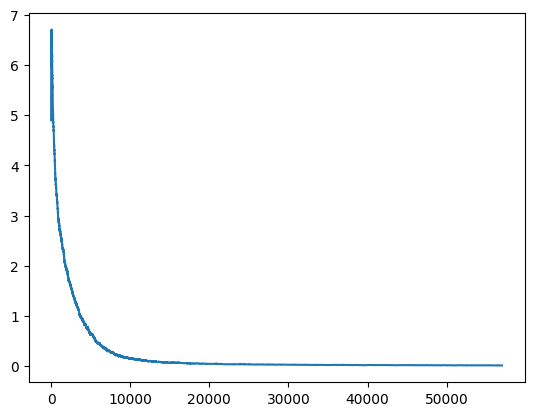

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Jesús hizo en presencia de sus discípulos otros muchos milagros que no han sido recogidos en este libro.']
["Wainma kasa anasü naa'inrapü'ükat Jesús no'upala na nikirajüinkana, tü kasa nütüjakat apüleerua Maleiwa nümüiwa. Otta nnojotsü tashajüin süpüshua sulu'u tü karalouktakat."]
["Naa'inrüin Jesús wainma kasa nütüjakat apüleerua Maleiwa nümüiwa su'upala tü wayuukolüirua. Nnojotsü pii'iyatüin achiki sulu'u tü karalouktakat."]


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x  2 americasnlp americasnlp 4.0K Mar 16 10:41 .
4.0K drwxrwxr-x 10 americasnlp americasnlp 4.0K Mar 16 18:57 ..
1.5M -rw-rw-r--  1 americasnlp americasnlp 1.5M Mar 16 10:22 all_texts_file.csv
4.0K -rw-rw-r--  1 americasnlp americasnlp  848 Mar 17 02:38 config.json
4.0K -rw-rw-r--  1 americasnlp americasnlp  184 Mar 17 02:38 generation_config.json
5.2G -rw-rw-r--  1 americasnlp americasnlp 5.2G Mar 17 02:38 pytorch_model.bin
4.7M -rw-rw-r--  1 americasnlp americasnlp 4.7M Mar 17 02:38 sentencepiece.bpe.model
4.0K -rw-rw-r--  1 americasnlp americasnlp 3.5K Mar 17 02:38 special_tokens_map.json
268K -rw-rw-r--  1 americasnlp americasnlp 267K Mar 16 10:22 spm_16k.model
 40K -rw-rw-r--  1 americasnlp americasnlp  37K Mar 16 10:22 spm_16k.vocab
4.7M -rw-rw-r--  1 americasnlp americasnlp 4.7M Mar 16 10:22 spm_nllb_268k.model
4.0K -rw-rw-r--  1 americasnlp americasnlp  570 Mar 17 02:38 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['Tüü jayeechi aisü tapüla']


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Chaanüii cintashaatasü tanüiki']

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['Miguel está contento con el criollo [que se quedó mi pajarito]']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Todavía cocina pajarito rojo']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/764 [00:00<?, ?it/s]

  0%|          | 0/764 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 15.37 41.3/17.9/12.0/9.1 (BP = 0.911 ratio = 0.915 hyp_len = 17832 ref_len = 19488)
chrF2++ = 32.06
BLEU = 18.93 46.7/23.6/15.8/11.9 (BP = 0.886 ratio = 0.892 hyp_len = 18662 ref_len = 20913)
chrF2++ = 42.79


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,way,esp,way_translated,esp_translated
676,"Ojutuushi taya sa a'ujee mootokaa aliikama 'inka, eweetüsü wanee p üliikü tapüleeru wa","Antes de ayer me caí de la moto, se me atravesó un burro","Antalaa kaꞋikaa, ojunuuüshi taya moto'opünaa, nülatiraakalaka taya wanee püliikü","Yo me lanzo al medio de un motín, hay un motín cerca"
5447,Ananajüsü tü wayuukolüirua naa'u Jesús wanaa sümaa nükachennüin sünain kuruusa. Otta na sülaülak...,"La gente estaba allí mirando, mientras las autoridades se burlaban de Jesús, diciendo:—Puesto qu...","Je tü wayuukolüirua, shi'rüinjase'e tü naa'inrakat Jesús. Otta na laülaayuukana, na'ülüjünaakala...",Los judíos alabaron Jesús y lo golpeaban con insultos. - ¿No eres tú el Mesías? ¡Pues sálvate a ...
2925,"Anakaja müleka jükaaliijale na wayuu eekai püreesain, müinjana aka püreesakai jia wanaa namaa. J...",Tengan siempre presentes a los encarcelados como si ustedes mismos se encontraran presos junto c...,"Anakaja müleka jümüliarüle naa'in na juwalayuukana eekai püreesain, maa aka jümülialain jia wana...",Tengan compasión de los que están en la cárcel como compañeros de prisión; tengan compasión de l...
6565,Nüsouktakalaka Jesús namüin:—Shiimüin sünain niainjachin Elías antüin palajana süpüla yapainjatü...,Jesús les contestó:—Es cierto que Elías ha de venir y ha de ponerlo todo en orden.,Nüsouktakalaka Jesús namüin: - Shiimüin sünain antüin Elías sünain anouktaa sukuaippa wayuu süpü...,Jesús le contestó: - Es cierto que Elías ha de venir primero para traer de la paz a toda la huma...
1670,Katünayaa müshii naya maa aka saa'in sütüna wuchii. Aippiruasüwai natüna wane'ewai nakua. Je ko'...,Cada uno de los cuatro seres vivientes tenía seis alas y eran todo ojos por fuera y por dentro. ...,"Je wane'ewai nakua na pienchishii kato'uchiikana, kasüpüshua'a ma'i no'u. Otta nayakana, ayatshi...","Sus mentes serán como de osota, armadas de poderosos aguijones que pertenecen al Reino.Ministros..."
6786,"Ja'itaina jia aapüin süchiki kasachiki sainküin mmakat süpüshua, nnojo jainkuuin aa'in sütüma. J...","Llegarán a oídos de ustedes noticias de guerras y rumores de conflictos bélicos. No se alarmen, ...","Ja'itaina jia aapüin süchiki kasachiki sainküin mmakat süpüshua, nnojo jainkuuin aa'in sütüma. J...","Cuando oigan noticias de guerras y rumores de conflictos bélicos, no se alarmen. Aunque todo eso..."
5277,"“ ‘Shiimüin ma'i tü tamakat jümüin: Chi wayuu eekai koo'omüin nütüma tü aapünakat nümüin, aapüne...","«Es cierto —asintió el rey—, pero yo les digo que a todo el que tiene, se le dará más. En cambio...",Shiimüin sünain niain aluwataainjachin chi aluwataashikai. Otta tayakai chi eekai nütüjain tü aa...,"Porque a todo el que tiene, aún se le dará más, y tendrá de sobra; pero al que no tiene, hasta l..."
472,"Tayakaa, talatüsü taya süka jemetüin jümüin","Yo, me alegro que les haya gustado.",Talatashaanashi taya süka talatüin ma'in taa'in jümüin.,"Yo sí, estoy contenta de tenerlos a todos."
3309,"Je nüntapa nünain, nümaashi nia Antioquíamüin, eejanale naya kettatüin wane juya natüma sünain o...","Cuando lo encontró, lo llevó consigo Antioquía. Y a lo largo de todo un año trabajaron los dos j...","Je nüntapa nia, no'unirüin nia nipialu'umüin tü outkajaaleekat cha'aya. Eeshi Pablo nümaa Bernab...","A su llegada, se puso en camino y pasó dos años con ellos, enseñando con gran exactitud en lo qu..."
1790,Eirakaataalasü joo taa'in iipünaamüin. Te'rataalakalaka joo chi Anneetchonkai sha'watüin cha'aya...,"Volví a mirar, y vi al Cordero de pie sobre el monte de Sion. Lo acompañaban los ciento cuarenta...","Eweeta müshia taya tachikua, te'rakalaka chi Anneetchonkai sha'watüin chaa naa'u chi Maleiwakai ...","Vi al Cordero, que estaba en pie del monte de Sion, mientras mensajeros llevaban el nombre del C..."
